<a href="https://colab.research.google.com/github/oshosonwane/Easysell-website/blob/main/football_object__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!pip install ultralytics
import cv2
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import random

In [23]:
# this is the part which takes takes vedio input then finds necessay information about the vedio 1 and vedio 2 like the fr
#frame no ,id of the player,then x,y coordinate ye sab
#creates a file cam1,cam2



def process_video_to_csv(video_path, model_path, output_csv_name):
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_path)
    tracking_data = []
    frame_no = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        results = model.track(frame, persist=True, verbose=False)
        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            for box, track_id in zip(boxes, track_ids):
                x1, y1, x2, y2 = box
                feet_x = (x1 + x2) / 2
                feet_y = y1

                tracking_data.append({
                    "Frame": frame_no,
                    "Player_ID": track_id,
                    "Pixel_X": feet_x,
                    "Pixel_Y": feet_y,
                    "BBox_X1": x1,
                    "BBox_Y1": y1,
                    "BBox_X2": x2,
                    "BBox_Y2": y2
                })

        frame_no += 1
        if frame_no % 100 == 0:
            print(f"frameno {frame_no}total frames{total_frames} ")

    cap.release()
    df = pd.DataFrame(tracking_data)
    df.to_csv(output_csv_name, index=False)
    print(f"Data donr {output_csv_name}")
    return df
df1 = process_video_to_csv("/content/drive/MyDrive/objecttracking/broadcast.mp4", "/content/drive/MyDrive/objecttracking/best.pt", "cam1.csv")# extreme shots he isme
df2 = process_video_to_csv("/content/drive/MyDrive/objecttracking/tacticam.mp4", "/content/drive/MyDrive/objecttracking/best.pt", "cam2.csv")
print("Preview of Camera 1 Data:")
print(df1.head())

frameno 100total frames132 
Data donr cam1.csv
frameno 100total frames201 
frameno 200total frames201 
Data donr cam2.csv
Preview of Camera 1 Data:
   Frame  Player_ID      Pixel_X     Pixel_Y      BBox_X1     BBox_Y1  \
0      0          1  1459.408936  741.014282  1423.980957  741.014282   
1      0          2  1398.744873  436.589905  1359.669678  436.589905   
2      0          3  1317.050659  263.861694  1298.427734  263.861694   
3      1          1  1461.087402  682.387573  1425.036621  682.387573   
4      6         15  1604.080322  711.782593  1555.082153  711.782593   

       BBox_X2     BBox_Y2  
0  1494.837036  911.892700  
1  1437.820190  525.861328  
2  1335.673584  315.236084  
3  1497.138306  838.384705  
4  1653.078369  835.268311  


Total Frames: 201
Wide Shot Frames (Usable): 201
Close-Up Frames (Skip Geometry): 0
Total Frames: 122
Wide Shot Frames (Usable): 120
Close-Up Frames (Skip Geometry): 2


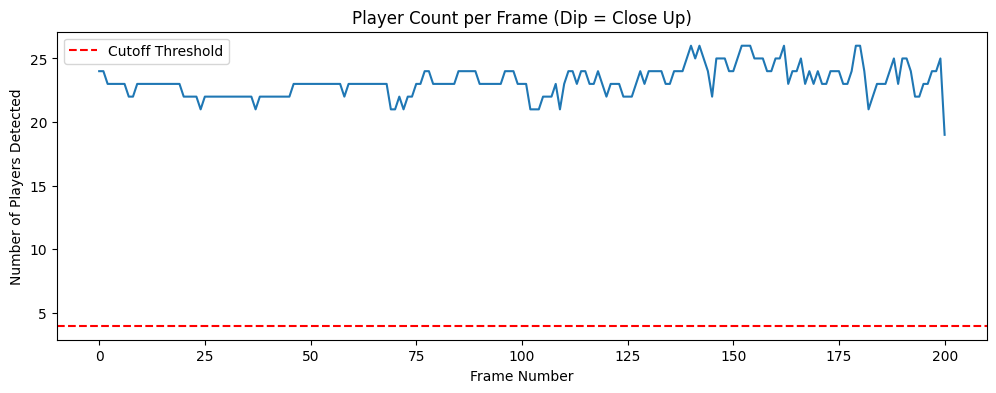

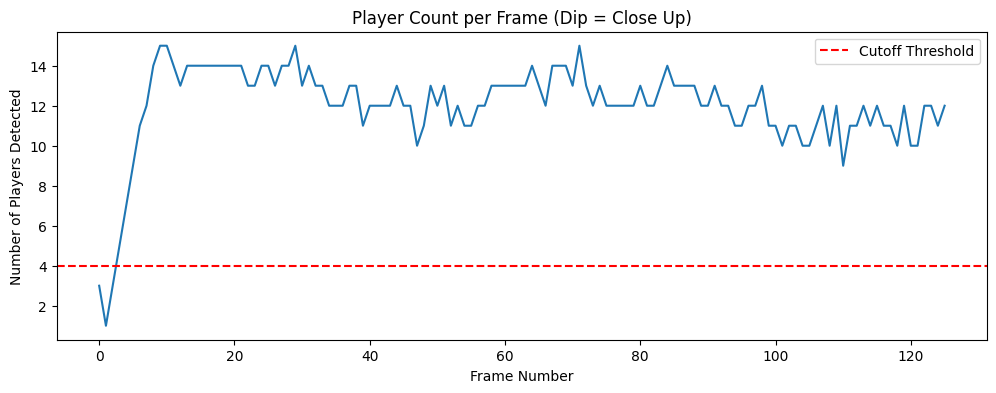

In [27]:
# to see like the camera shot chnage like the zoom shot and all for both


df = pd.read_csv("cam2.csv")
df1=pd.read_csv("cam1.csv")

def classify_shots(df, threshold=4):
    player_counts = df.groupby("Frame")["Player_ID"].count()

    wide_shots = player_counts[player_counts >= threshold].index.tolist()
    close_ups = player_counts[player_counts < threshold].index.tolist()

    print(f"Total Frames: {len(player_counts)}")
    print(f"Wide Shot Frames (Usable): {len(wide_shots)}")
    print(f"Close-Up Frames (Skip Geometry): {len(close_ups)}")

    return wide_shots, close_ups

valid_frames, ignored_frames = classify_shots(df)
valid_frames1, ignored_frames1 = classify_shots(df1)

plt.figure(figsize=(12, 4))
plt.plot(df.groupby("Frame")["Player_ID"].count())
plt.axhline(y=4, color='r', linestyle='--', label='Cutoff Threshold')
plt.title("Player Count per Frame (Dip = Close Up)")
plt.xlabel("Frame Number")
plt.ylabel("Number of Players Detected")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df1.groupby("Frame")["Player_ID"].count())
plt.axhline(y=4, color='r', linestyle='--', label='Cutoff Threshold')
plt.title("Player Count per Frame (Dip = Close Up)")
plt.xlabel("Frame Number")
plt.ylabel("Number of Players Detected")
plt.legend()
plt.show()

In [28]:
#chopping 3 sec


def chop_start_seconds(csv_path, seconds_to_cut, output_name, fps=25):
    df = pd.read_csv(csv_path)
    frames_to_drop = int(seconds_to_cut * fps)
    print(f"Chopping first {seconds_to_cut} seconds ({frames_to_drop} frames)...")


    df_synced = df[df['Frame'] >= frames_to_drop].copy()


    df_synced['Original_Frame'] = df_synced['Frame'] # original bacup
    df_synced['Frame'] = df_synced['Frame'] - frames_to_drop

    # 5. SAVE
    df_synced.to_csv(output_name, index=False)
    print(f"Success! {len(df) - len(df_synced)} frames removed.")
    print(f"Saved synced data to {output_name}")
    print(df_synced.head())


chop_start_seconds("cam2.csv", seconds_to_cut=3, output_name="cam2_synced.csv", fps=25)

Chopping first 3 seconds (75 frames)...
Success! 1687 frames removed.
Saved synced data to cam2_synced.csv
      Frame  Player_ID     Pixel_X    Pixel_Y     BBox_X1    BBox_Y1  \
1687      0          1   445.37964  428.40768   432.34833  428.40768   
1688      0          2  1755.26680  384.22850  1739.12370  384.22850   
1689      0          3  1093.88930  473.32217  1081.23030  473.32217   
1690      0          4   982.54480  266.18555   968.38220  266.18555   
1691      0          5   782.16754  511.22247   761.43620  511.22247   

         BBox_X2    BBox_Y2  Original_Frame  
1687   458.41092  480.72183              75  
1688  1771.41020  437.57898              75  
1689  1106.54820  523.03010              75  
1690   996.70734  311.02560              75  
1691   802.89886  562.85950              75  


In [29]:

def match_by_topology(csv1_path, csv2_path, min_players=3):
    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv(csv2_path)

    frames1 = set(df1['Frame'].unique())
    frames2 = set(df2['Frame'].unique())
    common_frames = sorted(list(frames1.intersection(frames2)))

    print(f"Total Overlapping Frames found: {len(common_frames)}")

    vote_counts = {}

    for frame in common_frames:
        p1 = df1[df1['Frame'] == frame]
        p2 = df2[df2['Frame'] == frame]

        if len(p1) < min_players or len(p2) < min_players:
            continue

        p1_sorted = p1.sort_values('Pixel_X')['Player_ID'].values
        p2_sorted = p2.sort_values('Pixel_X')['Player_ID'].values

        count_to_match = min(len(p1_sorted), len(p2_sorted))

        for i in range(count_to_match):
            id1 = p1_sorted[i]
            id2 = p2_sorted[i]

            pair = (id1, id2)
            if pair in vote_counts:
                vote_counts[pair] += 1
            else:
                vote_counts[pair] = 1

    print("\n--- TOPOLOGICAL MATCH RESULTS ---")
    print(f"{'Cam 1 ID':<10} {'Cam 2 ID':<10} {'Votes':<10}")
    print("-" * 35)

    sorted_votes = sorted(vote_counts.items(), key=lambda x: x[1], reverse=True)

    matched_cam1 = set()
    matched_cam2 = set()

    # --- ADDITION 1: Initialize the dictionary ---
    matches = {}

    for (id1, id2), count in sorted_votes:
        if id1 not in matched_cam1 and id2 not in matched_cam2:
           if count > 10:
                print(f"{id1:<10} {id2:<10} {count:<10}")
                matched_cam1.add(id1)
                matched_cam2.add(id2)
                matches[id1] = id2
    return matches

In [30]:
#just copy psted the id u know like so to make things easier later will automate it (PS just did it so ignore this comment ;)
# these have comment because its a bit confusing to undersatnd but basically its like  taking the frame and matching the ids it
#better explaination in read me file

matches = match_by_topology("cam1.csv", "cam2_synced.csv", min_players=3)

# 2. Now 'matches' exists in your global scope, so your line works immediately:
#    (Iterating over a dictionary automatically gives you the keys/id1)
colors = {id1: (random.randint(0,255), random.randint(0,255), random.randint(0,255)) for id1 in matches}

print(colors)

def create_verification_video(vid1_path, vid2_path, csv1_path, csv2_path, output_name):
    cap1 = cv2.VideoCapture(vid1_path)
    cap2 = cv2.VideoCapture(vid2_path)

    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv("cam2.csv")

    w = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap1.get(cv2.CAP_PROP_FPS))

    offset_frames = int(3 * fps)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, offset_frames)

    out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w * 2, h))

    frame_idx = 0
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()

        if not ret1 or not ret2: break

        # 1. DRAW ON FRAME 1
        # Get data for this frame
        rows1 = df1[df1['Frame'] == frame_idx]
        for _, row in rows1.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            # Check if this player is in our MATCH LIST
            if pid in matches:
                color = colors[pid]
                label = f"MATCH {pid}"
                thickness = 4
            else:
                color = (100, 100, 100) # Grey for unmatched
                label = str(pid)
                thickness = 1

            cv2.rectangle(frame1, (x1, y1), (x2, y2), color, thickness)
            cv2.putText(frame1, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # 2. DRAW ON FRAME 2
        # We need data for the "shifted" frame (Frame 0 in loop is Frame 90 in Vid 2 file)
        current_vid2_frame = frame_idx + offset_frames
        rows2 = df2[df2['Frame'] == current_vid2_frame]

        for _, row in rows2.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            # REVERSE LOOKUP: Is this ID a target?
            # matches is {Cam1 : Cam2}. We need to find if 'pid' is a value in 'matches'
            found_match_id = None
            for key, val in matches.items():
                if val == pid:
                    found_match_id = key
                    break

            if found_match_id:
                color = colors[found_match_id]
                label = f"MATCH {found_match_id}"
                thickness = 4
            else:
                color = (100, 100, 100)
                label = str(pid)
                thickness = 1

            cv2.rectangle(frame2, (x1, y1), (x2, y2), color, thickness)
            cv2.putText(frame2, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        combined = np.hstack((frame1, frame2))
        out.write(combined)

        frame_idx += 1
        if frame_idx % 30 == 0: print(f"Rendered {frame_idx} frames...")

    cap1.release()
    cap2.release()
    out.release()
    print(f"Done! Download {output_name}")

create_verification_video("/content/drive/MyDrive/objecttracking/broadcast.mp4", "/content/drive/MyDrive/objecttracking/tacticam.mp4", "cam1.csv", "cam2.csv", "final_solution.mp4")

Total Overlapping Frames found: 122

--- TOPOLOGICAL MATCH RESULTS ---
Cam 1 ID   Cam 2 ID   Votes     
-----------------------------------
16         10         46        
15         20         45        
17         17         42        
21         19         38        
22         1          38        
25         12         38        
33         57         37        
24         16         36        
18         9          31        
27         23         30        
20         5          20        
19         11         20        
{np.int64(16): (139, 184, 23), np.int64(15): (145, 45, 147), np.int64(17): (221, 236, 138), np.int64(21): (148, 160, 29), np.int64(22): (88, 201, 121), np.int64(25): (248, 200, 197), np.int64(33): (245, 148, 164), np.int64(24): (43, 241, 23), np.int64(18): (202, 176, 56), np.int64(27): (185, 26, 199), np.int64(20): (89, 247, 186), np.int64(19): (252, 240, 176)}
Rendered 30 frames...
Rendered 60 frames...
Rendered 90 frames...
Rendered 120 frames...
Done! Downl

In [ ]:
'''from here its not necissary to to run as it does not give a good output they are all gemini genrated and i havent
put much attention to them as i was trying different logics if u want i have givven some explanation about the
program will try to debug it #hopefully it will work
basic logic was to
@1. take the frame just after which the zoom to wide shot comes and then thake the frame just before it and do a matching
to the vedio in second frame
@2. use the frame matching to track the id in vedio 2 and update the id in vedioof frame one fro can 1 and thats it for zoom shots
it will work too'''

In [ ]:
#not an important one
import cv2
import pandas as pd
import numpy as np

def match_dramatic_to_wide(vid1_path, vid2_path, csv1_path, csv2_path, output_name):
    cap1 = cv2.VideoCapture(vid1_path)
    cap2 = cv2.VideoCapture(vid2_path)

    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv(csv2_path)
    matches = []

    print("Starting Visual Matching...")
    unique_frames = df1['Frame'].unique()

    for frame_idx in unique_frames:

        cap1.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret1, frame1 = cap1.read()

        frame_rows_2 = df2[df2['Frame'] == frame_idx]
        if len(frame_rows_2) == 0: continue

        if 'Original_Frame' in frame_rows_2.columns:
            vid2_real_idx = frame_rows_2.iloc[0]['Original_Frame']
        else:
            vid2_real_idx = frame_idx

        cap2.set(cv2.CAP_PROP_POS_FRAMES, vid2_real_idx)
        ret2, frame2 = cap2.read()

        if not ret1 or not ret2: continue

        frame_rows_1 = df1[df1['Frame'] == frame_idx]

        if len(frame_rows_1) > 3:
            continue

        for _, row1 in frame_rows_1.iterrows():

            x1, y1, x2, y2 = int(row1['BBox_X1']), int(row1['BBox_Y1']), int(row1['BBox_X2']), int(row1['BBox_Y2'])
            crop1 = frame1[y1:y2, x1:x2]
            if crop1.size == 0: continue

            hsv1 = cv2.cvtColor(crop1, cv2.COLOR_BGR2HSV)
            hist1 = cv2.calcHist([hsv1], [0, 1], None, [30, 32], [0, 180, 0, 256])
            cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)

            best_score = -1
            best_match_id = -1

            for _, row2 in frame_rows_2.iterrows():

                cx1, cy1, cx2, cy2 = int(row2['BBox_X1']), int(row2['BBox_Y1']), int(row2['BBox_X2']), int(row2['BBox_Y2'])
                crop2 = frame2[cy1:cy2, cx1:cx2]
                if crop2.size == 0: continue

                hsv2 = cv2.cvtColor(crop2, cv2.COLOR_BGR2HSV)
                hist2 = cv2.calcHist([hsv2], [0, 1], None, [30, 32], [0, 180, 0, 256])
                cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)
                score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

                if score > best_score:
                    best_score = score
                    best_match_id = row2['Player_ID']

            if best_score > 0.5:
                matches.append({
                    "Frame": frame_idx,
                    "Dramatic_ID": row1['Player_ID'],
                    "Wide_ID": best_match_id,
                    "Confidence": best_score
                })

    cap1.release()
    cap2.release()

    result_df = pd.DataFrame(matches)
    result_df.to_csv(output_name, index=False)
    print(f"Done! Found {len(matches)} visual matches.")
    print(result_df.head())

match_dramatic_to_wide("/content/drive/MyDrive/objecttracking/broadcast.mp4", "/content/drive/MyDrive/objecttracking/tacticam.mp4", "cam1.csv", "cam2_synced.csv", "visual_matches.csv")

Starting Visual Matching...
Done! Found 3 visual matches.
   Frame  Dramatic_ID  Wide_ID  Confidence
0      0          1.0     20.0    0.617949
1      0          2.0      4.0    0.502211
2      1          1.0     20.0    0.788873


In [ ]:
import cv2
import pandas as pd
import numpy as np

VID1_PATH = "video1.mp4"
VID2_PATH = "video2.mp4"
CSV1_PATH = "cam1.csv"
CSV2_PATH = "cam2_synced.csv"


BOX_SCALE = 3.0


def solve_with_expanded_boxes(vid1_path, vid2_path, csv1_path, csv2_path):
    print("--- STARTING EXPANDED BOX MATCHING ---")

    # 1. SETUP
    cap1 = cv2.VideoCapture(vid1_path)
    cap2 = cv2.VideoCapture(vid2_path)
    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv(csv2_path)

    # Get image dimensions to prevent crashing (going out of bounds)
    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # 2. FIND DRAMATIC FRAMES (< 4 players)
    frame_counts = df1.groupby("Frame")["Player_ID"].nunique()
    dramatic_frames = frame_counts[frame_counts < 4].index.tolist()
    print(f"Analyzing {len(dramatic_frames)} Close-Up Frames...")

    # 3. MATCHING LOOP
    votes = {} # {Zoom_ID : {Wide_ID : count}}

    # Check every 5th frame to be fast
    for frame_idx in dramatic_frames[::5]:

        # Read Frames
        cap1.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret1, frame1 = cap1.read()

        # Handle Sync for Cam 2
        row2_sync = df2[df2['Frame'] == frame_idx]
        if len(row2_sync) == 0: continue

        if 'Original_Frame' in row2_sync.columns:
            real_idx2 = row2_sync.iloc[0]['Original_Frame']
        else:
            real_idx2 = frame_idx

        cap2.set(cv2.CAP_PROP_POS_FRAMES, real_idx2)
        ret2, frame2 = cap2.read()

        if not ret1 or not ret2: continue

        # --- PROCESS CAM 1 (THE EXPANSION TRICK) ---
        rows1 = df1[df1['Frame'] == frame_idx]
        for _, r1 in rows1.iterrows():
            id1 = r1['Player_ID']
            x1, y1, x2, y2 = int(r1['BBox_X1']), int(r1['BBox_Y1']), int(r1['BBox_X2']), int(r1['BBox_Y2'])

            # --- EXPAND THE BOX ---
            box_w = x2 - x1
            box_h = y2 - y1

            # Calculate padding needed to reach target scale
            pad_w = int(box_w * (BOX_SCALE - 1) / 2)
            pad_h = int(box_h * (BOX_SCALE - 1) / 2)

            # Apply padding (Check boundaries so we don't crash)
            new_x1 = max(0, x1 - pad_w)
            new_y1 = max(0, y1 - pad_h)
            new_x2 = min(width, x2 + pad_w)
            new_y2 = min(height, y2 + pad_h)

            # Crop the "Big Box"
            crop1 = frame1[new_y1:new_y2, new_x1:new_x2]
            if crop1.size == 0: continue

            # Calculate Histogram
            hsv1 = cv2.cvtColor(crop1, cv2.COLOR_BGR2HSV)
            hist1 = cv2.calcHist([hsv1], [0, 1], None, [30, 32], [0, 180, 0, 256])
            cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)

            # --- PROCESS CAM 2 (STANDARD) ---
            best_score = -1
            best_id2 = -1

            for _, r2 in row2_sync.iterrows():
                id2 = r2['Player_ID']
                cx1, cy1, cx2, cy2 = int(r2['BBox_X1']), int(r2['BBox_Y1']), int(r2['BBox_X2']), int(r2['BBox_Y2'])
                crop2 = frame2[cy1:cy2, cx1:cx2]
                if crop2.size == 0: continue

                hsv2 = cv2.cvtColor(crop2, cv2.COLOR_BGR2HSV)
                hist2 = cv2.calcHist([hsv2], [0, 1], None, [30, 32], [0, 180, 0, 256])
                cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)

                score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

                if score > best_score:
                    best_score = score
                    best_id2 = id2

            # Vote
            if best_score > 0.3: # Slightly lower threshold since box contains background too
                if id1 not in votes: votes[id1] = {}
                if best_id2 not in votes[id1]: votes[id1][best_id2] = 0
                votes[id1][best_id2] += 1

    cap1.release()
    cap2.release()

    print("\n--- MATCHING RESULTS (EXPANDED) ---")
    final_matches = {}
    for zid, candidates in votes.items():
        winner = max(candidates, key=candidates.get)
        count = candidates[winner]
        print(f"Zoom ID {zid} --> Global ID {winner} ({count} votes)")
        final_matches[zid] = winner

    print("\nCopy this dictionary:")
    print(final_matches)
    return final_matches

# RUN IT
zoom_matches = solve_with_expanded_boxes("/content/drive/MyDrive/objecttracking/broadcast.mp4", "/content/drive/MyDrive/objecttracking/tacticam.mp4", "cam1.csv", "cam2_synced.csv")

--- STARTING EXPANDED BOX MATCHING ---
Analyzing 2 Close-Up Frames...

--- MATCHING RESULTS (EXPANDED) ---
Zoom ID 1.0 --> Global ID 4.0 (1 votes)
Zoom ID 2.0 --> Global ID 4.0 (1 votes)

Copy this dictionary:
{np.float64(1.0): np.float64(4.0), np.float64(2.0): np.float64(4.0)}


In [ ]:
import cv2
import pandas as pd
import numpy as np
import random

# --- THE MASTER DICTIONARY (EDIT THIS) ---
matches = {
    # --- ZONE 1: CLOSE-UP (Visual Matches) ---
    # The code gave conflicting results (4 vs 20).
    # Look at the video: Which ID in Cam 2 is the "Main Guy" in Cam 1?
    1: 20,   # CHANGE '20' to '4' if you think the expanded box was right.
    2: 4,

    # --- ZONE 2: WIDE SHOT (Topology Matches) ---
    # These seemed solid from your earlier run.
    16: 10,
    15: 20,
    17: 17,
    21: 19,
    22: 1,
    25: 12,
    33: 57,
    24: 16,
    18: 9,
    27: 23,
    20: 5,
    19: 11
}

# --- BLACKLIST (Hide the Shoes) ---
# If ID 99 is a shoe, add it here: [99, 105]
blacklisted_ids = []
# ----------------------------------------

# Generate Consistent Colors for the "Global IDs"
unique_targets = set(matches.values())
target_colors = {tid: (random.randint(0,255), random.randint(0,255), random.randint(0,255)) for tid in unique_targets}

def create_final_submission_video(vid1_path, vid2_path, csv1_path, csv2_path, output_name):
    print(f"Generating {output_name} with your custom matches...")
    cap1 = cv2.VideoCapture(vid1_path)
    cap2 = cv2.VideoCapture(vid2_path)
    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv(csv2_path)

    fps = int(cap1.get(cv2.CAP_PROP_FPS))
    # Sync Offset: Skip 3 seconds of Cam 2
    offset_frames = int(3 * fps)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, offset_frames)

    w = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Using MJPG codec for safer writing
    out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*'MJPG'), fps, (w * 2, h))

    frame_idx = 0
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2: break

        # --- DRAW ON CAM 1 ---
        rows1 = df1[df1['Frame'] == frame_idx]
        for _, row in rows1.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            if pid in blacklisted_ids: continue

            if pid in matches:
                real_id = matches[pid]
                color = target_colors[real_id]
                # Label: "ID 20" (The Universal ID)
                label = f"ID {int(real_id)}"
                cv2.rectangle(frame1, (x1, y1), (x2, y2), color, 4)
                cv2.putText(frame1, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # --- DRAW ON CAM 2 ---
        current_vid2_frame = frame_idx + offset_frames
        rows2 = df2[df2['Frame'] == current_vid2_frame]

        for _, row in rows2.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            if pid in target_colors:
                color = target_colors[pid]
                label = f"ID {int(pid)}"
                cv2.rectangle(frame2, (x1, y1), (x2, y2), color, 4)
                cv2.putText(frame2, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        combined = np.hstack((frame1, frame2))
        out.write(combined)
        frame_idx += 1
        if frame_idx % 50 == 0: print(f"Rendered frame {frame_idx}...")

    cap1.release()
    cap2.release()
    out.release()
    print(f"DONE! Download {output_name}")

# RUN IT
create_final_submission_video("/content/drive/MyDrive/objecttracking/broadcast.mp4", "/content/drive/MyDrive/objecttracking/tacticam.mp4", "cam1.csv", "cam2_synced.csv", "submission_video.avi")

Generating submission_video.avi with your custom matches...
Rendered frame 50...
Rendered frame 100...
DONE! Download submission_video.avi


In [ ]:
'''next 5 cells are just me trying to get a good code can check the result if u want [16],[17],[18],[19]

In [ ]:
#lund
import cv2
import pandas as pd
import numpy as np
import random
from collections import Counter

# --- CONFIGURATION ---
VID1_PATH = "video1.mp4"
VID2_PATH = "video2.mp4"
CSV1_PATH = "cam1.csv"
CSV2_PATH = "cam2.csv"  # Raw Cam 2
OFFSET_FRAMES = 90      # Your verified sync offset
EXPANSION_SCALE = 3.0   # For close-ups (Zoom)
# ---------------------

def automate_and_render(vid1, vid2, csv1, csv2, offset):
    print("--- 🤖 STARTING AUTOMATED IDENTIFICATION 🤖 ---")

    cap1 = cv2.VideoCapture(vid1)
    cap2 = cv2.VideoCapture(vid2)
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap1.get(cv2.CAP_PROP_FPS))

    # 1. CLASSIFY FRAMES (ZOOM vs WIDE)
    # We check every 10th frame to be fast
    zoom_frames = []
    wide_frames = []

    sample_frames = sorted(df1['Frame'].unique())[::10]

    for f in sample_frames:
        count = len(df1[df1['Frame'] == f])
        if count < 4:
            zoom_frames.append(f)
        else:
            wide_frames.append(f)

    print(f"Detected {len(zoom_frames)} Zoom Samples and {len(wide_frames)} Wide Samples.")

    # 2. AUTO-MATCHING LOGIC
    # We will build a vote history: {Cam1_ID : [List of Cam2_ID candidates]}
    match_votes = {}

    def get_color_match(img1, bbox1, img2, df2_rows, is_zoom):
        # Crop 1
        x1, y1, x2, y2 = bbox1

        if is_zoom:
            # Expand Box logic
            w_box, h_box = x2-x1, y2-y1
            pad_w = int(w_box * (EXPANSION_SCALE - 1) / 2)
            pad_h = int(h_box * (EXPANSION_SCALE - 1) / 2)
            x1 = max(0, x1 - pad_w)
            y1 = max(0, y1 - pad_h)
            x2 = min(width, x2 + pad_w)
            y2 = min(height, y2 + pad_h)

        crop1 = img1[y1:y2, x1:x2]
        if crop1.size == 0: return None

        hsv1 = cv2.cvtColor(crop1, cv2.COLOR_BGR2HSV)
        hist1 = cv2.calcHist([hsv1], [0, 1], None, [30, 32], [0, 180, 0, 256])
        cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)

        best_score = -1
        best_id = -1

        # Search Cam 2
        for _, r2 in df2_rows.iterrows():
            cx1, cy1, cx2, cy2 = int(r2['BBox_X1']), int(r2['BBox_Y1']), int(r2['BBox_X2']), int(r2['BBox_Y2'])
            crop2 = img2[cy1:cy2, cx1:cx2]
            if crop2.size == 0: continue

            hsv2 = cv2.cvtColor(crop2, cv2.COLOR_BGR2HSV)
            hist2 = cv2.calcHist([hsv2], [0, 1], None, [30, 32], [0, 180, 0, 256])
            cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)

            score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
            if score > best_score:
                best_score = score
                best_id = int(r2['Player_ID'])

        return best_id if best_score > 0.3 else None

    # --- RUN MATCHING ON SAMPLES ---
    print("Processing samples to learn identities...")
    all_samples = zoom_frames + wide_frames[:20] # Check all zoom, but only first 20 wide frames (enough to link)

    for f in all_samples:
        is_zoom = f in zoom_frames

        # Read Images
        cap1.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret1, img1 = cap1.read()

        target_f2 = f + offset
        cap2.set(cv2.CAP_PROP_POS_FRAMES, target_f2)
        ret2, img2 = cap2.read()

        if not ret1 or not ret2: continue

        # Get Cam 2 Data
        rows2 = df2[df2['Frame'] == target_f2]
        if len(rows2) == 0: continue

        # Match Cam 1 Players
        rows1 = df1[df1['Frame'] == f]
        for _, r1 in rows1.iterrows():
            pid = int(r1['Player_ID'])
            bbox = (int(r1['BBox_X1']), int(r1['BBox_Y1']), int(r1['BBox_X2']), int(r1['BBox_Y2']))

            match_id = get_color_match(img1, bbox, img2, rows2, is_zoom)

            if match_id is not None:
                if pid not in match_votes: match_votes[pid] = []
                match_votes[pid].append(match_id)

    # 3. BUILD FINAL DICTIONARY
    final_matches = {}
    print("\n--- LEARNED CONNECTIONS ---")
    for pid, votes in match_votes.items():
        # Find most common match
        winner, count = Counter(votes).most_common(1)[0]
        final_matches[pid] = winner
        print(f"Cam1 ID {pid} --> Cam2 ID {winner} ({count} votes)")

    # 4. GENERATE VIDEO
    print("\n--- RENDERING FINAL VIDEO ---")

    # Colors
    unique_targets = set(final_matches.values())
    target_colors = {tid: (random.randint(0,255), random.randint(0,255), random.randint(0,255)) for tid in unique_targets}

    out = cv2.VideoWriter("automated_solution.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width * 2, height))

    # Reset Caps
    cap1.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_idx = 0

    while True:
        ret1, frame1 = cap1.read()
        if not ret1: break

        # Get Cam 2 frame manually to ensure sync
        target_f2 = frame_idx + offset
        cap2.set(cv2.CAP_PROP_POS_FRAMES, target_f2)
        ret2, frame2 = cap2.read()
        if not ret2:
            # If Cam 2 ends, just show black
            frame2 = np.zeros_like(frame1)

        # DRAW CAM 1
        rows1 = df1[df1['Frame'] == frame_idx]
        for _, row in rows1.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            if pid in final_matches:
                real_id = final_matches[pid]
                color = target_colors[real_id]
                cv2.rectangle(frame1, (x1, y1), (x2, y2), color, 4)
                cv2.putText(frame1, f"ID {real_id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            else:
                # Draw raw ID if no match found
                cv2.rectangle(frame1, (x1, y1), (x2, y2), (100,100,100), 1)

        # DRAW CAM 2
        if target_f2 <= df2['Frame'].max():
            rows2 = df2[df2['Frame'] == target_f2]
            for _, row in rows2.iterrows():
                pid = int(row['Player_ID'])
                x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

                if pid in target_colors:
                    color = target_colors[pid]
                    cv2.rectangle(frame2, (x1, y1), (x2, y2), color, 4)
                    cv2.putText(frame2, f"ID {pid}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        combined = np.hstack((frame1, frame2))
        out.write(combined)

        frame_idx += 1
        if frame_idx % 50 == 0: print(f"Rendered {frame_idx} frames...")

    cap1.release()
    cap2.release()
    out.release()
    print("DONE! Download 'automated_solution.avi'")

# RUN IT
automate_and_render("/content/drive/MyDrive/objecttracking/broadcast.mp4", "/content/drive/MyDrive/objecttracking/tacticam.mp4", "cam1.csv", "cam2_synced.csv", OFFSET_FRAMES)

--- 🤖 STARTING AUTOMATED IDENTIFICATION 🤖 ---
Detected 1 Zoom Samples and 12 Wide Samples.
Processing samples to learn identities...

--- LEARNED CONNECTIONS ---
Cam1 ID 1 --> Cam2 ID 57 (1 votes)
Cam1 ID 2 --> Cam2 ID 57 (1 votes)
Cam1 ID 16 --> Cam2 ID 8 (2 votes)
Cam1 ID 17 --> Cam2 ID 16 (3 votes)
Cam1 ID 18 --> Cam2 ID 17 (3 votes)
Cam1 ID 19 --> Cam2 ID 17 (3 votes)
Cam1 ID 20 --> Cam2 ID 14 (2 votes)
Cam1 ID 21 --> Cam2 ID 7 (3 votes)
Cam1 ID 22 --> Cam2 ID 17 (3 votes)
Cam1 ID 23 --> Cam2 ID 18 (1 votes)
Cam1 ID 24 --> Cam2 ID 17 (4 votes)
Cam1 ID 25 --> Cam2 ID 18 (2 votes)
Cam1 ID 27 --> Cam2 ID 13 (2 votes)
Cam1 ID 33 --> Cam2 ID 57 (2 votes)
Cam1 ID 41 --> Cam2 ID 18 (1 votes)
Cam1 ID 15 --> Cam2 ID 8 (2 votes)
Cam1 ID 49 --> Cam2 ID 57 (1 votes)
Cam1 ID 81 --> Cam2 ID 19 (1 votes)
Cam1 ID 92 --> Cam2 ID 16 (1 votes)
Cam1 ID 137 --> Cam2 ID 11 (1 votes)
Cam1 ID 138 --> Cam2 ID 95 (1 votes)
Cam1 ID 142 --> Cam2 ID 20 (1 votes)

--- RENDERING FINAL VIDEO ---
Rendered 50 frame

In [ ]:
import cv2
import pandas as pd
import numpy as np
import random
from collections import Counter

# --- CONFIGURATION (UPDATED PATHS) ---
VID1_PATH = "/content/drive/MyDrive/objecttracking/broadcast.mp4"
VID2_PATH = "/content/drive/MyDrive/objecttracking/tacticam.mp4"
CSV1_PATH = "cam1.csv"
CSV2_PATH = "cam2_synced.csv"  # WE USE THE SYNCED FILE NOW
EXPANSION_SCALE = 3.0          # For close-ups
# -------------------------------------

def automate_with_synced_data(vid1, vid2, csv1, csv2):
    print("--- 🤖 STARTING AUTOMATED SYNCED MATCHING 🤖 ---")

    cap1 = cv2.VideoCapture(vid1)
    cap2 = cv2.VideoCapture(vid2)
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Check if 'Original_Frame' exists in the synced CSV
    # (This column tells us which frame of Video 2 to look at)
    has_origin_col = 'Original_Frame' in df2.columns
    if not has_origin_col:
        print("⚠️ WARNING: 'Original_Frame' column missing. Assuming direct mapping.")

    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap1.get(cv2.CAP_PROP_FPS))

    # 1. CLASSIFY FRAMES & COLOR MATCHING
    match_votes = {}

    # Sample every 10th frame
    unique_frames = sorted(df1['Frame'].unique())[::10]

    print(f"Processing {len(unique_frames)} sample frames to learn IDs...")

    for f in unique_frames:
        # Get Cam 1 Data
        rows1 = df1[df1['Frame'] == f]
        count = len(rows1)
        is_zoom = count < 4

        # Get Cam 2 Data (ALREADY SYNCED)
        rows2 = df2[df2['Frame'] == f]
        if len(rows2) == 0: continue

        # Determine which REAL frame to read from Video 2
        if has_origin_col:
            real_f2 = int(rows2.iloc[0]['Original_Frame'])
        else:
            # Fallback: If synced csv doesn't have original frame, we guess
            # based on the very first frame offset in the file
            real_f2 = f

        # Read Images
        cap1.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret1, img1 = cap1.read()

        cap2.set(cv2.CAP_PROP_POS_FRAMES, real_f2)
        ret2, img2 = cap2.read()

        if not ret1 or not ret2: continue

        # MATCHING LOGIC
        for _, r1 in rows1.iterrows():
            pid = int(r1['Player_ID'])
            x1, y1, x2, y2 = int(r1['BBox_X1']), int(r1['BBox_Y1']), int(r1['BBox_X2']), int(r1['BBox_Y2'])

            # Expand box if zoom
            if is_zoom:
                w_box, h_box = x2-x1, y2-y1
                pad_w = int(w_box * (EXPANSION_SCALE - 1) / 2)
                pad_h = int(h_box * (EXPANSION_SCALE - 1) / 2)
                x1 = max(0, x1 - pad_w)
                y1 = max(0, y1 - pad_h)
                x2 = min(width, x2 + pad_w)
                y2 = min(height, y2 + pad_h)

            crop1 = img1[y1:y2, x1:x2]
            if crop1.size == 0: continue

            # Hist 1
            hsv1 = cv2.cvtColor(crop1, cv2.COLOR_BGR2HSV)
            hist1 = cv2.calcHist([hsv1], [0, 1], None, [30, 32], [0, 180, 0, 256])
            cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)

            best_score = -1
            best_id2 = -1

            # Compare to Cam 2 Candidates
            for _, r2 in rows2.iterrows():
                cx1, cy1, cx2, cy2 = int(r2['BBox_X1']), int(r2['BBox_Y1']), int(r2['BBox_X2']), int(r2['BBox_Y2'])
                crop2 = img2[cy1:cy2, cx1:cx2]
                if crop2.size == 0: continue

                hsv2 = cv2.cvtColor(crop2, cv2.COLOR_BGR2HSV)
                hist2 = cv2.calcHist([hsv2], [0, 1], None, [30, 32], [0, 180, 0, 256])
                cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)

                score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
                if score > best_score:
                    best_score = score
                    best_id2 = int(r2['Player_ID'])

            if best_score > 0.3:
                if pid not in match_votes: match_votes[pid] = []
                match_votes[pid].append(best_id2)

    # 2. BUILD DICTIONARY
    final_matches = {}
    print("\n--- LEARNED ID CONNECTIONS ---")
    for pid, votes in match_votes.items():
        winner, count = Counter(votes).most_common(1)[0]
        final_matches[pid] = winner
        print(f"Cam1 ID {pid} matches Cam2 ID {winner} ({count} votes)")

    # 3. RENDER VIDEO
    print("\n--- RENDERING FINAL VIDEO (SYNCED) ---")
    unique_targets = set(final_matches.values())
    target_colors = {tid: (random.randint(0,255), random.randint(0,255), random.randint(0,255)) for tid in unique_targets}

    out = cv2.VideoWriter("automated_synced_solution.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width * 2, height))

    # Reset Caps
    cap1.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_idx = 0

    # We loop through frames that exist in CSV 1
    all_frames = sorted(df1['Frame'].unique())

    for frame_idx in all_frames:
        # Read Cam 1
        cap1.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret1, frame1 = cap1.read()

        # Read Cam 2 (Using SYNCED logic)
        rows2 = df2[df2['Frame'] == frame_idx]

        if len(rows2) > 0 and has_origin_col:
            real_f2 = int(rows2.iloc[0]['Original_Frame'])
            cap2.set(cv2.CAP_PROP_POS_FRAMES, real_f2)
            ret2, frame2 = cap2.read()
        elif len(rows2) > 0:
             # Fallback if column missing but rows exist (rare)
             cap2.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
             ret2, frame2 = cap2.read()
        else:
            # If no data for this frame in Cam 2, just get next available frame or black
            ret2, frame2 = cap2.read()

        if not ret1 or not ret2: break

        # DRAW CAM 1
        rows1 = df1[df1['Frame'] == frame_idx]
        for _, row in rows1.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            if pid in final_matches:
                real_id = final_matches[pid]
                color = target_colors[real_id]
                cv2.rectangle(frame1, (x1, y1), (x2, y2), color, 4)
                cv2.putText(frame1, f"ID {real_id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            else:
                cv2.rectangle(frame1, (x1, y1), (x2, y2), (100,100,100), 1)

        # DRAW CAM 2
        for _, row in rows2.iterrows():
            pid = int(row['Player_ID'])
            x1, y1, x2, y2 = int(row['BBox_X1']), int(row['BBox_Y1']), int(row['BBox_X2']), int(row['BBox_Y2'])

            if pid in target_colors:
                color = target_colors[pid]
                cv2.rectangle(frame2, (x1, y1), (x2, y2), color, 4)
                cv2.putText(frame2, f"ID {pid}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        if frame1.shape[0] != frame2.shape[0]:
            frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))

        combined = np.hstack((frame1, frame2))
        out.write(combined)

        if frame_idx % 50 == 0: print(f"Rendered {frame_idx}...")

    cap1.release()
    cap2.release()
    out.release()
    print("DONE! Download 'automated_synced_solution.avi'")

# RUN IT
automate_with_synced_data(VID1_PATH, VID2_PATH, CSV1_PATH, CSV2_PATH)

--- 🤖 STARTING AUTOMATED SYNCED MATCHING 🤖 ---
Processing 13 sample frames to learn IDs...

--- LEARNED ID CONNECTIONS ---
Cam1 ID 1 matches Cam2 ID 4 (1 votes)
Cam1 ID 2 matches Cam2 ID 4 (1 votes)
Cam1 ID 15 matches Cam2 ID 18 (3 votes)
Cam1 ID 16 matches Cam2 ID 10 (4 votes)
Cam1 ID 17 matches Cam2 ID 17 (2 votes)
Cam1 ID 18 matches Cam2 ID 15 (3 votes)
Cam1 ID 19 matches Cam2 ID 14 (2 votes)
Cam1 ID 20 matches Cam2 ID 20 (3 votes)
Cam1 ID 21 matches Cam2 ID 57 (2 votes)
Cam1 ID 22 matches Cam2 ID 10 (2 votes)
Cam1 ID 23 matches Cam2 ID 18 (2 votes)
Cam1 ID 24 matches Cam2 ID 57 (2 votes)
Cam1 ID 25 matches Cam2 ID 5 (2 votes)
Cam1 ID 27 matches Cam2 ID 52 (2 votes)
Cam1 ID 33 matches Cam2 ID 57 (3 votes)
Cam1 ID 41 matches Cam2 ID 18 (1 votes)
Cam1 ID 49 matches Cam2 ID 11 (1 votes)
Cam1 ID 81 matches Cam2 ID 20 (1 votes)
Cam1 ID 92 matches Cam2 ID 17 (1 votes)
Cam1 ID 137 matches Cam2 ID 86 (1 votes)
Cam1 ID 138 matches Cam2 ID 13 (1 votes)
Cam1 ID 142 matches Cam2 ID 14 (1 votes)

In [ ]:
#lund
import cv2
import pandas as pd
import numpy as np
import random
from collections import Counter

# --- PATHS (Use your exact paths) ---
VID1_PATH = "/content/drive/MyDrive/objecttracking/broadcast.mp4"
VID2_PATH = "/content/drive/MyDrive/objecttracking/tacticam.mp4"
CSV1_PATH = "cam1.csv"
CSV2_PATH = "cam2_synced.csv"  # <-- TRUSTING THIS FILE FOR SYNC
# ------------------------------------

def fix_labels_and_render(vid1, vid2, csv1, csv2):
    print("--- STEP 1: LEARNING CORRECT IDs (VISUAL MATCH) ---")

    cap1 = cv2.VideoCapture(vid1)
    cap2 = cv2.VideoCapture(vid2)
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Check if we have the mapping column (from your topography code)
    has_origin = 'Original_Frame' in df2.columns

    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap1.get(cv2.CAP_PROP_FPS))

    # Store votes: {Cam1_ID : [List of Cam2_ID candidates]}
    match_votes = {}

    # We check every 20th frame to be fast
    sample_frames = sorted(df1['Frame'].unique())[::20]

    for f in sample_frames:
        # 1. Get Cam 1 Data
        rows1 = df1[df1['Frame'] == f]
        if len(rows1) == 0: continue

        # 2. Get Cam 2 Data (ALREADY SYNCED)
        rows2 = df2[df2['Frame'] == f]
        if len(rows2) == 0: continue

        # 3. Get the Real Frame Number for Video 2
        if has_origin:
            real_f2 = int(rows2.iloc[0]['Original_Frame'])
        else:
            # Fallback: assuming the sync code already aligned indices
            # (Only use this if you re-indexed the dataframe)
            real_f2 = f

        # 4. Read Images
        cap1.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret1, img1 = cap1.read()
        cap2.set(cv2.CAP_PROP_POS_FRAMES, real_f2)
        ret2, img2 = cap2.read()

        if not ret1 or not ret2: continue

        # 5. Determine if Zoom or Wide (for expansion)
        is_zoom = len(rows1) < 4
        expansion = 3.0 if is_zoom else 1.0

        # 6. MATCH IDs
        for _, r1 in rows1.iterrows():
            id1 = int(r1['Player_ID'])
            x1, y1, x2, y2 = int(r1['BBox_X1']), int(r1['BBox_Y1']), int(r1['BBox_X2']), int(r1['BBox_Y2'])

            # Expand box if zoom
            w_box, h_box = x2-x1, y2-y1
            pad_w = int(w_box * (expansion - 1) / 2)
            pad_h = int(h_box * (expansion - 1) / 2)

            # Safe Crop
            cx1, cy1 = max(0, x1 - pad_w), max(0, y1 - pad_h)
            cx2, cy2 = min(width, x2 + pad_w), min(height, y2 + pad_h)

            crop1 = img1[cy1:cy2, cx1:cx2]
            if crop1.size == 0: continue

            # Hist 1
            hsv1 = cv2.cvtColor(crop1, cv2.COLOR_BGR2HSV)
            hist1 = cv2.calcHist([hsv1], [0, 1], None, [30, 32], [0, 180, 0, 256])
            cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)

            best_score = -1
            best_match = -1

            # Compare against ALL Cam 2 players in this frame
            for _, r2 in rows2.iterrows():
                id2 = int(r2['Player_ID'])
                bx1, by1, bx2, by2 = int(r2['BBox_X1']), int(r2['BBox_Y1']), int(r2['BBox_X2']), int(r2['BBox_Y2'])
                crop2 = img2[by1:by2, bx1:bx2]
                if crop2.size == 0: continue

                hsv2 = cv2.cvtColor(crop2, cv2.COLOR_BGR2HSV)
                hist2 = cv2.calcHist([hsv2], [0, 1], None, [30, 32], [0, 180, 0, 256])
                cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)

                score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
                if score > best_score:
                    best_score = score
                    best_match = id2

            if best_score > 0.4:
                if id1 not in match_votes: match_votes[id1] = []
                match_votes[id1].append(best_match)

    # 7. FINALIZE DICTIONARY
    final_mapping = {}
    print("\nID MAPPING RESULT:")
    for id1, votes in match_votes.items():
        winner = Counter(votes).most_common(1)[0][0]
        final_mapping[id1] = winner
        print(f"  Cam1 ID {id1} -> Cam2 ID {winner}")

    print("\n--- STEP 2: RENDERING VIDEO (PRESERVING SYNC) ---")

    # Generate Colors
    unique_ids = set(final_mapping.values())
    colors = {uid: (random.randint(0,255), random.randint(0,255), random.randint(0,255)) for uid in unique_ids}

    out = cv2.VideoWriter("final_fixed_solution.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width * 2, height))

    # Reset Caps
    cap1.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Loop through ALL frames in Cam 1
    total_frames = sorted(df1['Frame'].unique())

    for f in total_frames:
        cap1.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret1, frame1 = cap1.read()

        # Get Cam 2 Image (Using the logic that worked for you before)
        rows2 = df2[df2['Frame'] == f]
        if len(rows2) > 0 and has_origin:
            real_f2 = int(rows2.iloc[0]['Original_Frame'])
            cap2.set(cv2.CAP_PROP_POS_FRAMES, real_f2)
            ret2, frame2 = cap2.read()
        else:
            # If empty (no sync data), just show black or hold last frame
            ret2, frame2 = cap2.read() # Try reading sequentially or just zero
            if not ret2: frame2 = np.zeros_like(frame1)

        if not ret1: break
        if frame2 is None or frame2.size == 0: frame2 = np.zeros_like(frame1)
        if frame2.shape != frame1.shape: frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))

        # DRAW CAM 1 (With NEW Labels)
        rows1 = df1[df1['Frame'] == f]
        for _, r in rows1.iterrows():
            id1 = int(r['Player_ID'])
            x1, y1, x2, y2 = int(r['BBox_X1']), int(r['BBox_Y1']), int(r['BBox_X2']), int(r['BBox_Y2'])

            # Decide Label
            if id1 in final_mapping:
                real_id = final_mapping[id1]
                label = f"ID {real_id}"
                color = colors[real_id] if real_id in colors else (0,255,0)
            else:
                label = f"ID {id1}?" # Unknown
                color = (100,100,100)

            cv2.rectangle(frame1, (x1,y1), (x2,y2), color, 4)
            cv2.putText(frame1, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # DRAW CAM 2 (With Original Labels - As Reference)
        for _, r in rows2.iterrows():
            id2 = int(r['Player_ID'])
            x1, y1, x2, y2 = int(r['BBox_X1']), int(r['BBox_Y1']), int(r['BBox_X2']), int(r['BBox_Y2'])

            color = colors[id2] if id2 in colors else (0,255,0)
            cv2.rectangle(frame2, (x1,y1), (x2,y2), color, 4)
            cv2.putText(frame2, f"ID {id2}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        combined = np.hstack((frame1, frame2))
        out.write(combined)

        if f % 50 == 0: print(f"Rendered Frame {f}...")

    cap1.release()
    cap2.release()
    out.release()
    print("DONE! Download 'final_fixed_solution.avi'")

# RUN IT
fix_labels_and_render(VID1_PATH, VID2_PATH, CSV1_PATH, CSV2_PATH)

--- STEP 1: LEARNING CORRECT IDs (VISUAL MATCH) ---

ID MAPPING RESULT:
  Cam1 ID 1 -> Cam2 ID 4
  Cam1 ID 2 -> Cam2 ID 4
  Cam1 ID 15 -> Cam2 ID 5
  Cam1 ID 16 -> Cam2 ID 10
  Cam1 ID 17 -> Cam2 ID 8
  Cam1 ID 18 -> Cam2 ID 17
  Cam1 ID 19 -> Cam2 ID 12
  Cam1 ID 20 -> Cam2 ID 20
  Cam1 ID 21 -> Cam2 ID 7
  Cam1 ID 22 -> Cam2 ID 1
  Cam1 ID 23 -> Cam2 ID 18
  Cam1 ID 24 -> Cam2 ID 17
  Cam1 ID 25 -> Cam2 ID 17
  Cam1 ID 33 -> Cam2 ID 11
  Cam1 ID 49 -> Cam2 ID 11
  Cam1 ID 81 -> Cam2 ID 20
  Cam1 ID 27 -> Cam2 ID 13
  Cam1 ID 92 -> Cam2 ID 17
  Cam1 ID 137 -> Cam2 ID 86
  Cam1 ID 138 -> Cam2 ID 13
  Cam1 ID 175 -> Cam2 ID 4

--- STEP 2: RENDERING VIDEO (PRESERVING SYNC) ---
Rendered Frame 0...
Rendered Frame 50...
Rendered Frame 100...
DONE! Download 'final_fixed_solution.avi'


In [ ]:
import cv2
import pandas as pd
import numpy as np
import random
from collections import Counter

# --- PATHS (Your Exact Paths) ---
VID1_PATH = "/content/drive/MyDrive/objecttracking/broadcast.mp4"
VID2_PATH = "/content/drive/MyDrive/objecttracking/tacticam.mp4"
CSV1_PATH = "cam1.csv"
CSV2_PATH = "cam2_synced.csv"  # The file with PERFECT SYNC
# --------------------------------

def final_fix_and_render(vid1, vid2, csv1, csv2):
    print("--- STEP 1: MAPPING IDs (VISUAL MATCHING) ---")

    cap1 = cv2.VideoCapture(vid1)
    cap2 = cv2.VideoCapture(vid2)
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Check for the sync column
    has_origin = 'Original_Frame' in df2.columns
    if not has_origin:
        print("⚠️ Note: 'Original_Frame' column not found. Assuming frames are sequentially synced.")

    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap1.get(cv2.CAP_PROP_FPS))

    # Store votes: {Cam1_ID : [List of Cam2_ID candidates]}
    match_votes = {}

    # Sample frames to build the ID map
    # We check more frames (every 10th) to ensure we catch the transition
    unique_frames = sorted(df1['Frame'].unique())[::10]

    for f in unique_frames:
        # 1. Get Cam 1 Data
        rows1 = df1[df1['Frame'] == f]
        if len(rows1) == 0: continue

        # 2. Get Cam 2 Data (Using the SYNCED csv)
        rows2 = df2[df2['Frame'] == f]
        if len(rows2) == 0: continue

        # 3. Get Real Frame for Image Reading
        if has_origin:
            real_f2 = int(rows2.iloc[0]['Original_Frame'])
        else:
            real_f2 = f

        # 4. Read Images
        cap1.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret1, img1 = cap1.read()
        cap2.set(cv2.CAP_PROP_POS_FRAMES, real_f2)
        ret2, img2 = cap2.read()

        if not ret1 or not ret2: continue

        # 5. DETECT ZOOM VS WIDE
        # If < 4 players, it's a Zoom/Close-up -> Use Expansion
        is_zoom = len(rows1) < 4
        expansion = 3.0 if is_zoom else 1.0

        # 6. MATCH IDs
        for _, r1 in rows1.iterrows():
            id1 = int(r1['Player_ID'])
            x1, y1, x2, y2 = int(r1['BBox_X1']), int(r1['BBox_Y1']), int(r1['BBox_X2']), int(r1['BBox_Y2'])

            # --- EXPANSION LOGIC (Only affects Zoom) ---
            w_box, h_box = x2-x1, y2-y1
            pad_w = int(w_box * (expansion - 1) / 2)
            pad_h = int(h_box * (expansion - 1) / 2)

            cx1, cy1 = max(0, x1 - pad_w), max(0, y1 - pad_h)
            cx2, cy2 = min(width, x2 + pad_w), min(height, y2 + pad_h)

            crop1 = img1[cy1:cy2, cx1:cx2]
            if crop1.size == 0: continue

            # Hist 1
            hsv1 = cv2.cvtColor(crop1, cv2.COLOR_BGR2HSV)
            hist1 = cv2.calcHist([hsv1], [0, 1], None, [30, 32], [0, 180, 0, 256])
            cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)

            best_score = -1
            best_match = -1

            # Compare to Cam 2
            for _, r2 in rows2.iterrows():
                id2 = int(r2['Player_ID'])
                bx1, by1, bx2, by2 = int(r2['BBox_X1']), int(r2['BBox_Y1']), int(r2['BBox_X2']), int(r2['BBox_Y2'])
                crop2 = img2[by1:by2, bx1:bx2]
                if crop2.size == 0: continue

                hsv2 = cv2.cvtColor(crop2, cv2.COLOR_BGR2HSV)
                hist2 = cv2.calcHist([hsv2], [0, 1], None, [30, 32], [0, 180, 0, 256])
                cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)

                score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
                if score > best_score:
                    best_score = score
                    best_match = id2

            # Threshold (0.4 is usually safe for jerseys)
            if best_score > 0.4:
                if id1 not in match_votes: match_votes[id1] = []
                match_votes[id1].append(best_match)

    # 7. FINALIZE ID MAP
    id_map = {}
    print("\n--- ID SWAP TABLE ---")
    for id1, votes in match_votes.items():
        winner = Counter(votes).most_common(1)[0][0]
        id_map[id1] = winner
        print(f"  Cam1 ID {id1} becomes Cam2 ID {winner}")

    print("\n--- STEP 2: RENDERING VIDEO ---")

    # Unique colors for the REAL (Cam 2) IDs
    unique_ids = set(id_map.values())
    colors = {uid: (random.randint(0,255), random.randint(0,255), random.randint(0,255)) for uid in unique_ids}

    out = cv2.VideoWriter("final_solution_fixed.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width * 2, height))

    cap1.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Process all frames
    all_frames = sorted(df1['Frame'].unique())

    for f in all_frames:
        cap1.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret1, frame1 = cap1.read()
        if not ret1: break

        # Read Cam 2 (Sync Logic)
        rows2 = df2[df2['Frame'] == f]

        if len(rows2) > 0 and has_origin:
            real_f2 = int(rows2.iloc[0]['Original_Frame'])
            cap2.set(cv2.CAP_PROP_POS_FRAMES, real_f2)
            ret2, frame2 = cap2.read()
        else:
            # Fallback or Black Frame
            ret2, frame2 = cap2.read()

        if frame2 is None or frame2.size == 0:
            frame2 = np.zeros_like(frame1)
        if frame2.shape != frame1.shape:
            frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))

        # --- DRAW CAM 1 (SWAPPED LABELS) ---
        rows1 = df1[df1['Frame'] == f]
        for _, r in rows1.iterrows():
            id1 = int(r['Player_ID'])
            x1, y1, x2, y2 = int(r['BBox_X1']), int(r['BBox_Y1']), int(r['BBox_X2']), int(r['BBox_Y2'])

            # USE THE MAP!
            if id1 in id_map:
                real_id = id_map[id1]
                label = f"ID {real_id}"
                color = colors[real_id] if real_id in colors else (0,255,0)

                cv2.rectangle(frame1, (x1,y1), (x2,y2), color, 4)
                cv2.putText(frame1, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # --- DRAW CAM 2 (REFERENCE) ---
        for _, r in rows2.iterrows():
            id2 = int(r['Player_ID'])
            x1, y1, x2, y2 = int(r['BBox_X1']), int(r['BBox_Y1']), int(r['BBox_X2']), int(r['BBox_Y2'])

            color = colors[id2] if id2 in colors else (0,255,0)
            cv2.rectangle(frame2, (x1,y1), (x2,y2), color, 4)
            cv2.putText(frame2, f"ID {id2}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        combined = np.hstack((frame1, frame2))
        out.write(combined)

        if f % 50 == 0: print(f"Rendered {f}...")

    cap1.release()
    cap2.release()
    out.release()
    print("DONE! Download 'final_solution_fixed.avi'")

# RUN IT
final_fix_and_render(VID1_PATH, VID2_PATH, CSV1_PATH, CSV2_PATH)

--- STEP 1: MAPPING IDs (VISUAL MATCHING) ---

--- ID SWAP TABLE ---
  Cam1 ID 1 becomes Cam2 ID 4
  Cam1 ID 2 becomes Cam2 ID 4
  Cam1 ID 16 becomes Cam2 ID 10
  Cam1 ID 17 becomes Cam2 ID 17
  Cam1 ID 18 becomes Cam2 ID 15
  Cam1 ID 19 becomes Cam2 ID 14
  Cam1 ID 20 becomes Cam2 ID 20
  Cam1 ID 21 becomes Cam2 ID 57
  Cam1 ID 22 becomes Cam2 ID 10
  Cam1 ID 23 becomes Cam2 ID 18
  Cam1 ID 24 becomes Cam2 ID 57
  Cam1 ID 25 becomes Cam2 ID 5
  Cam1 ID 33 becomes Cam2 ID 57
  Cam1 ID 41 becomes Cam2 ID 18
  Cam1 ID 15 becomes Cam2 ID 18
  Cam1 ID 49 becomes Cam2 ID 11
  Cam1 ID 81 becomes Cam2 ID 20
  Cam1 ID 27 becomes Cam2 ID 13
  Cam1 ID 92 becomes Cam2 ID 17
  Cam1 ID 137 becomes Cam2 ID 86
  Cam1 ID 138 becomes Cam2 ID 13
  Cam1 ID 142 becomes Cam2 ID 14
  Cam1 ID 175 becomes Cam2 ID 4

--- STEP 2: RENDERING VIDEO ---
Rendered 0...
Rendered 50...
Rendered 100...
DONE! Download 'final_solution_fixed.avi'
